In [311]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

filename = r'C:\Users\Froxo\OneDrive\Escritorio\Corsika\Non_Binary_output_files_MC_Condor_DAT_1_Shower\Data_particle_1_energy_1.0E+06_angle_25_run_149.dat'
file = "Data_particle_1_energy_1.0E+06_angle_25_run_149.dat"

column_names = ['x', 'y', 'z', 't', 'px', 'py', 'pz', 'energy']

particles_df = pd.read_csv(filename, delimiter=" ", names=column_names, header=None)

In [312]:
# Asegurar de quitar todos los valores nulos
particles_df = particles_df.dropna().reset_index(drop=True)

# Creación de una nueva distancia "r" que especifica la distancia con respecto al centro de la cascada (o área de detectores)
particles_df['r'] = np.sqrt(particles_df['x']**2 + particles_df['y']**2)

# Ordenar las partículas desde la más cercana al centro a la más lejana (con respecto a la distancia r)
particles_df = particles_df.sort_values(by='r', ascending=True).reset_index(drop=True)

# Eliminar las columnas de los momentums 'px', 'py', 'pz' ya que no son necesarias
particles_df = particles_df.drop(columns=['px', 'z', 'py', 'pz'])

# Filtrar las partículas detectadas únicamente por el arreglo de detectores CONDOR
particles_df = particles_df[(particles_df['x'] >= -61) & (particles_df['x'] <= 61) &
                            (particles_df['y'] >= -56.5) & (particles_df['y'] <= 56.5)].reset_index(drop=True)

In [313]:
particles_df

,x,y,t,energy,r
0,0.000587,0.000593,46423.656,21.239660,0.000835
1,0.001125,0.000024,46423.656,0.124538,0.001125
2,-0.000231,0.002994,46423.656,668.930481,0.003003
3,0.000919,-0.004064,46423.650,19.930814,0.004167
4,-0.001052,-0.004121,46423.650,37.685609,0.004253
...,...,...,...,...,...
687282,-60.619057,56.429350,46461.645,0.029377,82.818727
687283,-60.721893,56.333275,46426.836,0.008203,82.828655
687284,60.697887,56.406340,46578.094,0.005748,82.860779
687285,-60.844860,56.487030,46444.430,0.015208,83.023380


In [314]:
# Obtener el nombre del archivo para etiquetas
import re
match = re.search(r'particle_(\d+)_energy_(\S+)_angle_(\d+)_run_(\d+)', file)
if match:
    particle_id = int(match.group(1))
    incidence_energy = float(match.group(2))
    incidence_angle = int(match.group(3))
else:
    raise ValueError("Nombre de archivo no tiene el formato esperado")

# Agregar columnas de etiquetas
particles_df['particle_id'] = particle_id
particles_df['incidence_energy'] = incidence_energy
particles_df['incidence_angle'] = incidence_angle

# Reordenar las columnas
new_column_order = ['x', 'y', 'r', 't', 'energy', 'particle_id', 'incidence_energy', 'incidence_angle']
particles_df = particles_df[new_column_order]

In [315]:
# Normalización/Estandarización
# scaler = StandardScaler()  # Alternativamente, usa MinMaxScaler() si prefieres normalización entre 0 y 1
# particles_df[['x', 'y', 't', 'energy']] = scaler.fit_transform(particles_df[['x', 'y', 't', 'energy']])

In [316]:
# Manejo de outliers
# En este caso, usamos el rango intercuartil para identificar outliers de energía y eliminarlos si están fuera de los límites
Q1 = particles_df.quantile(0.1)
Q3 = particles_df.quantile(0.9)
IQR = Q3 - Q1
# Mantener sólo las filas que no son outliers
particles_df = particles_df[~((particles_df < (Q1 - 1.5 * IQR)) | (particles_df > (Q3 + 1.5 * IQR))).any(axis=1)].reset_index(drop=True)

In [317]:
particles_df['t'] = particles_df['t'] - particles_df['t'].min()

particles_df = particles_df.sort_values(by='t', ascending=True).reset_index(drop=True)

In [318]:
# Guardar un dataframe para análisis
particles_dfa = particles_df[['x', 'y', 'r', 't', 'energy']]

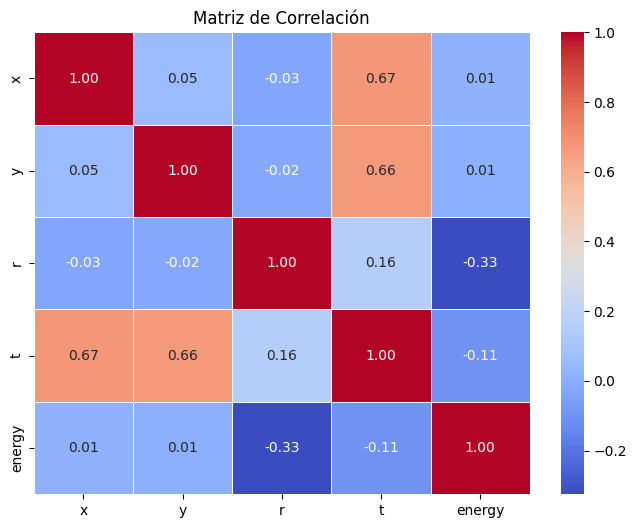

In [319]:
# Calcula la matriz de correlación
correlation_matrix = particles_dfa.corr()

# Configura el tamaño del gráfico
plt.figure(figsize=(8, 6))

# Crea el mapa de calor con seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Agrega título
plt.title('Matriz de Correlación')

# Muestra el gráfico
plt.show()

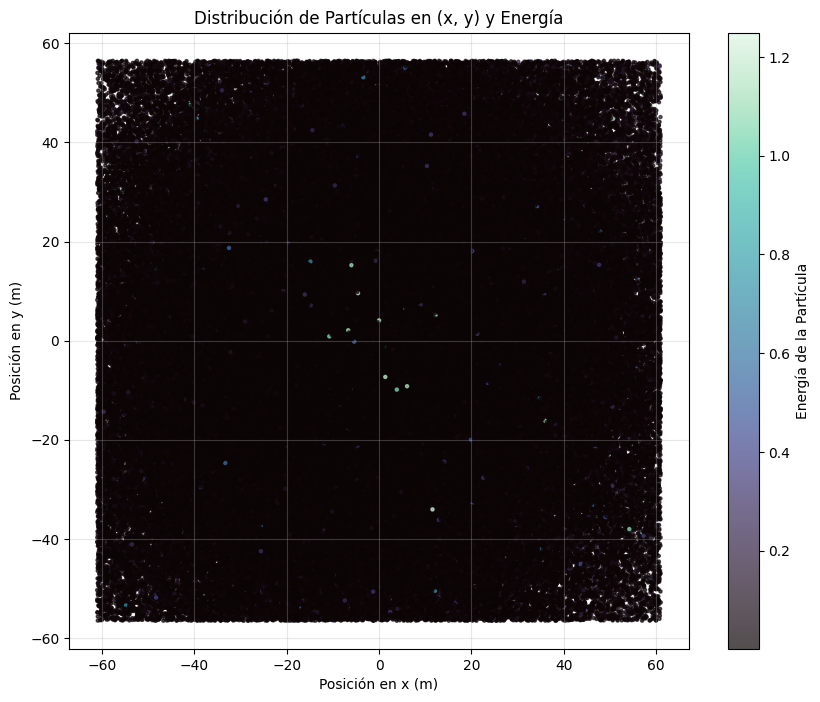

In [320]:
# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear un scatter plot para la distribución de las partículas en (x, y) y colorear por la energía
plt.scatter(particles_df['x'], particles_df['y'], c=particles_df['energy'], cmap='mako', s=5, alpha=0.7)

plt.grid(alpha=0.3)

# Agregar un color bar para indicar la escala de energía
plt.colorbar(label='Energía de la Partícula')

# Agregar etiquetas y título
plt.xlabel('Posición en x (m)')
plt.ylabel('Posición en y (m)')
plt.title('Distribución de Partículas en (x, y) y Energía')

# Mostrar el gráfico
plt.show()

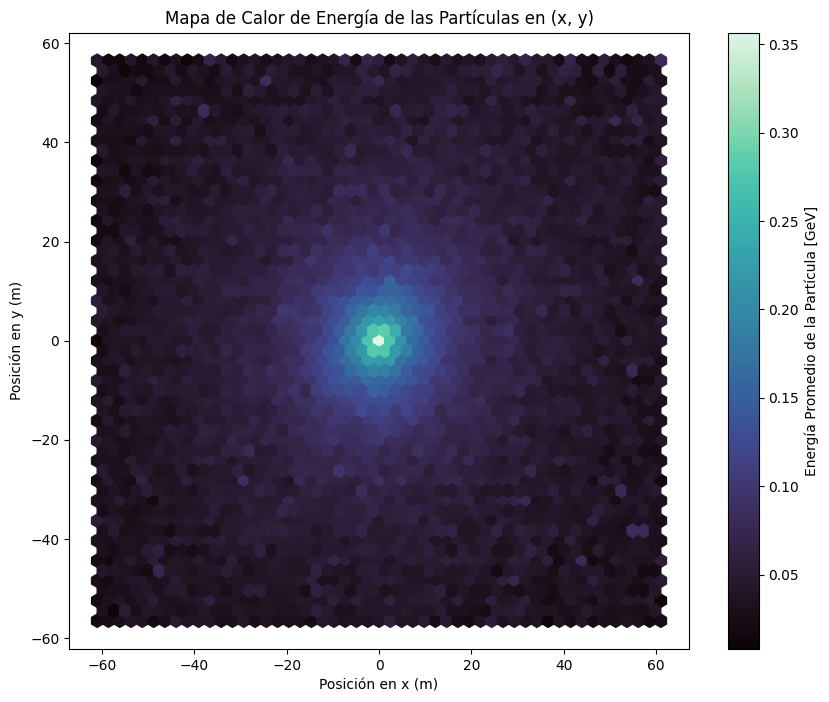

In [321]:
# Crear un mapa de calor usando un gráfico de hexbin
plt.figure(figsize=(10, 8))
hb = plt.hexbin(particles_df['x'], particles_df['y'], C=particles_df['energy'], gridsize=50, cmap='mako', reduce_C_function=np.mean)

# Agregar una barra de color para la escala de energía
plt.colorbar(hb, label='Energía Promedio de la Partícula [GeV]')

# Agregar etiquetas y título
plt.xlabel('Posición en x (m)')
plt.ylabel('Posición en y (m)')
plt.title('Mapa de Calor de Energía de las Partículas en (x, y)')

# Mostrar el gráfico
plt.show()

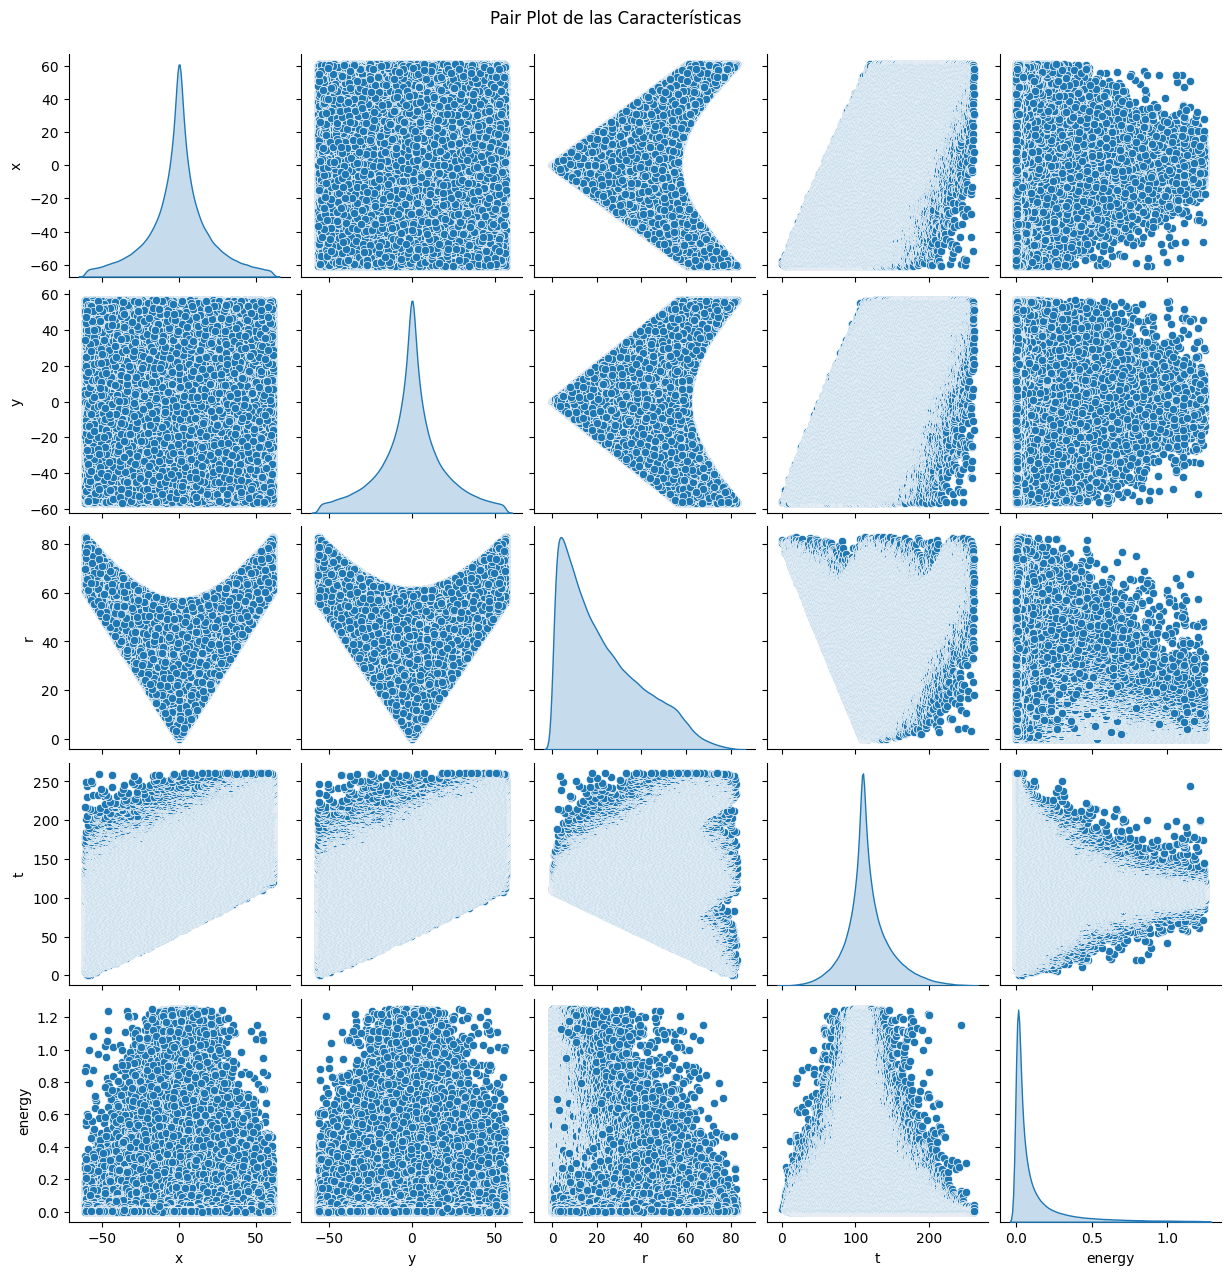

In [322]:
# Creación de Pairplot para ver la relación entre cada característica
sns.pairplot(particles_dfa, diag_kind='kde')
plt.suptitle('Pair Plot de las Características', y=1.02)
plt.show()

In [330]:
# Supongamos que tienes columnas 'x', 'y', 't' en el dataframe, ya en nanosegundos.

# 1. Crear bins espaciales (x, y)
# Definimos el tamaño de cada bin espacial. Por ejemplo, una cuadrícula de 5x5.
num_bins_x = 50  # Número de bins en el eje x
num_bins_y = 50  # Número de bins en el eje y
x_bins = np.linspace(particles_df['x'].min(), particles_df['x'].max(), num_bins_x)
y_bins = np.linspace(particles_df['y'].min(), particles_df['y'].max(), num_bins_y)

# 2. Crear bins temporales
# Definimos los intervalos de tiempo, por ejemplo, de 1 nanosegundo
time_bin_size = 1  # Tamaño del bin temporal en nanosegundos
t_bins = np.arange(particles_df['t'].min(), particles_df['t'].max(), time_bin_size)

# 3. Asignar cada partícula a un bin espacial y temporal
particles_df['x_bin'] = pd.cut(particles_df['x'], bins=x_bins, labels=False, include_lowest=True)
particles_df['y_bin'] = pd.cut(particles_df['y'], bins=y_bins, labels=False, include_lowest=True)
particles_df['t_bin'] = pd.cut(particles_df['t'], bins=t_bins, labels=False, include_lowest=True)

# 4. Agrupar por bins espaciales y temporales y contar partículas
binned_particles = particles_df.groupby(['x_bin', 'y_bin', 't_bin']).size().reset_index(name='particle_count')

# Visualizamos el DataFrame binalizado
particles_df

,x,y,r,t,energy,particle_id,incidence_energy,incidence_angle,x_bin,y_bin,t_bin
0,-57.921494,-55.959965,80.538296,0.000,0.019146,1,1000000.0,25,1,0,0.0
1,-59.795773,-55.445587,81.545984,0.199,0.017628,1,1000000.0,25,0,0,0.0
2,-58.832783,-55.288822,80.735062,0.983,0.036611,1,1000000.0,25,0,0,0.0
3,-59.192955,-54.294014,80.322138,3.000,0.067151,1,1000000.0,25,0,0,2.0
4,-58.196896,-55.902275,80.696611,3.726,0.030461,1,1000000.0,25,1,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
657795,30.069326,39.484330,49.630401,261.046,0.003155,1,1000000.0,25,36,41,NaN
657796,55.833385,35.438280,66.130466,261.058,0.011072,1,1000000.0,25,46,39,NaN
657797,53.252920,50.926144,73.684093,261.063,0.042662,1,1000000.0,25,45,46,NaN
657798,30.846985,21.148596,37.400529,261.066,0.021740,1,1000000.0,25,36,33,NaN


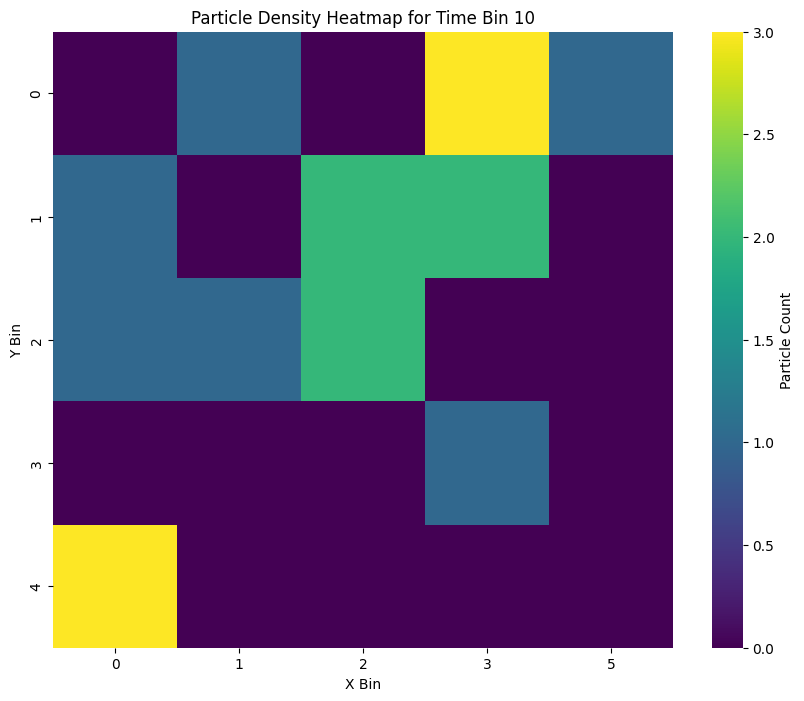

In [324]:
# Tomemos un intervalo de tiempo específico (por ejemplo, el bin temporal 10)
time_bin_to_plot = 10

# Filtrar las partículas que caen en ese bin temporal específico
particles_in_time_bin = binned_particles[binned_particles['t_bin'] == time_bin_to_plot]

# Crear un heatmap basado en la densidad de partículas (conteo)
heatmap_data = particles_in_time_bin.pivot_table(index='y_bin', columns='x_bin', values='particle_count', fill_value=0)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Particle Count'})
plt.title(f'Particle Density Heatmap for Time Bin {time_bin_to_plot}')
plt.xlabel('X Bin')
plt.ylabel('Y Bin')
plt.show()

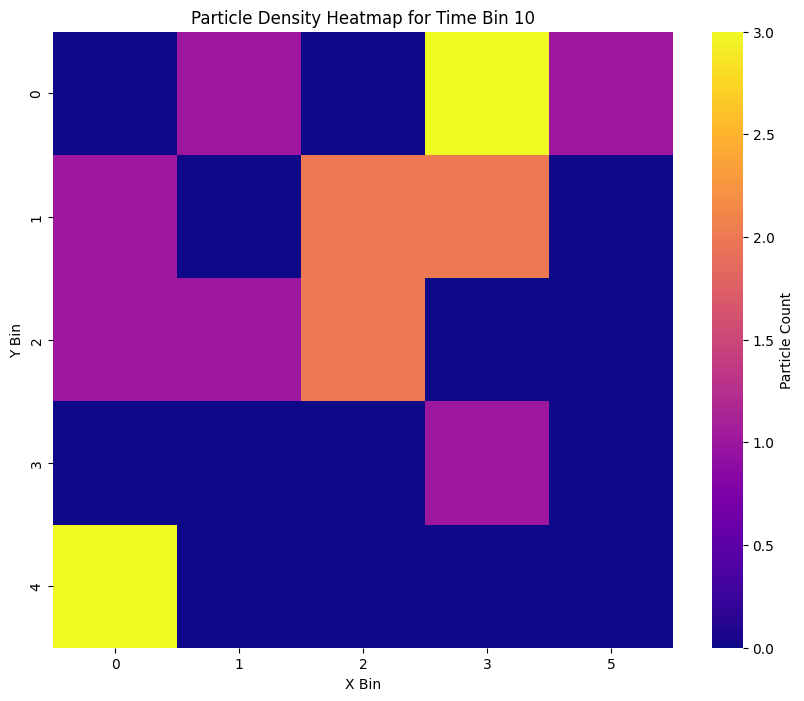

In [329]:
# Tomemos un intervalo de tiempo específico (por ejemplo, el bin temporal 10)
time_bin_to_plot = 10

# Filtrar las partículas que caen en ese bin temporal específico
particles_in_time_bin = binned_particles[binned_particles['t_bin'] == time_bin_to_plot]

# Crear un heatmap basado en la densidad de partículas (conteo)
heatmap_data = particles_in_time_bin.pivot_table(index='y_bin', columns='x_bin', values='particle_count', fill_value=0)

# Verificar si hay datos en heatmap_data
if heatmap_data.empty:
    print(f"No hay partículas en el bin temporal {time_bin_to_plot}.")
else:
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap='plasma', cbar_kws={'label': 'Particle Count'})
    plt.title(f'Particle Density Heatmap for Time Bin {time_bin_to_plot}')
    plt.xlabel('X Bin')
    plt.ylabel('Y Bin')
    plt.show()

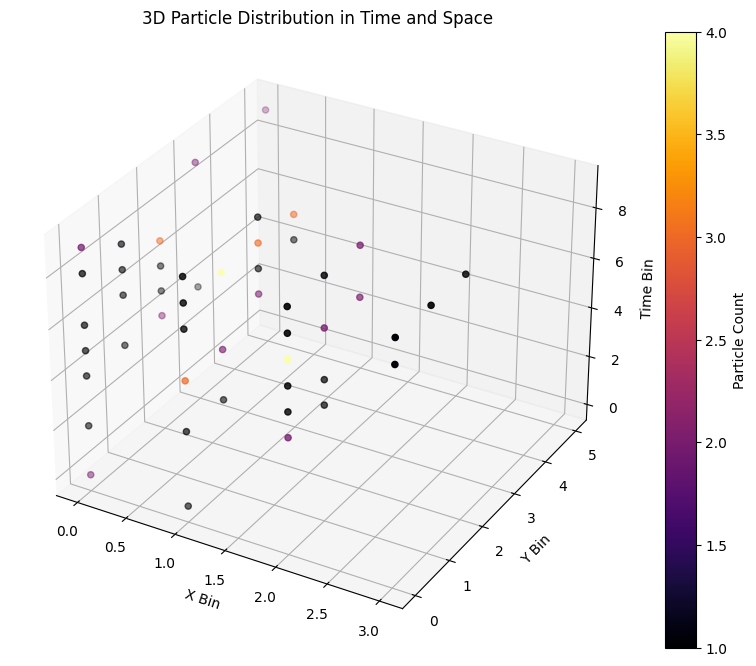

In [326]:
# Filtrar datos para un rango de bins temporales para evitar saturar el gráfico
filtered_particles = binned_particles[binned_particles['t_bin'] < 10]  # Por ejemplo, 10 primeros bins

# Configurar el gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotear las partículas
img = ax.scatter(filtered_particles['x_bin'], filtered_particles['y_bin'], filtered_particles['t_bin'], 
                 c=filtered_particles['particle_count'], cmap='inferno', marker='o')

# Etiquetas
ax.set_xlabel('X Bin')
ax.set_ylabel('Y Bin')
ax.set_zlabel('Time Bin')
plt.colorbar(img, label='Particle Count')

plt.title('3D Particle Distribution in Time and Space')
plt.show()